### Estimation of Muon Decay Time

In [52]:
#NOTE: Future work section: hierarchical model with multiple data sets

# Pip imports
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [53]:
# Simulate Data
def gen_data(theta, w, num_samples): #theta[0]: lambda, theta[1]: alpha, theta[2]: beta
    # Generate each distribution
    num_muons = int(w*num_samples)
    num_background = num_samples - num_muons
    obs_time_range = [1, 19999]
    # muon_distr = (obs_time_range[1] * np.random.exponential(scale=theta[0]*10**3, size=(num_muons,))).astype(np.uint64) #This needs to be normalized to obs_time_range
    muon_distr = np.random.exponential(scale=theta[0]*10**3, size=(num_muons,)).astype(np.uint64) #This needs to be normalized to obs_time_range
    muon_distr[muon_distr==0] = 1
    background_distr = np.random.uniform(low=obs_time_range[0], high=obs_time_range[1] + 1, size=(num_background,)).astype(np.uint64)
    background_distr[background_distr==0] = 1

    mixed_distr = np.concatenate([muon_distr, background_distr])
    np.random.shuffle(mixed_distr)

    return mixed_distr

19.991 0.001


Text(0.5, 0, 'Measured Decay Times ($\\mu s$)')

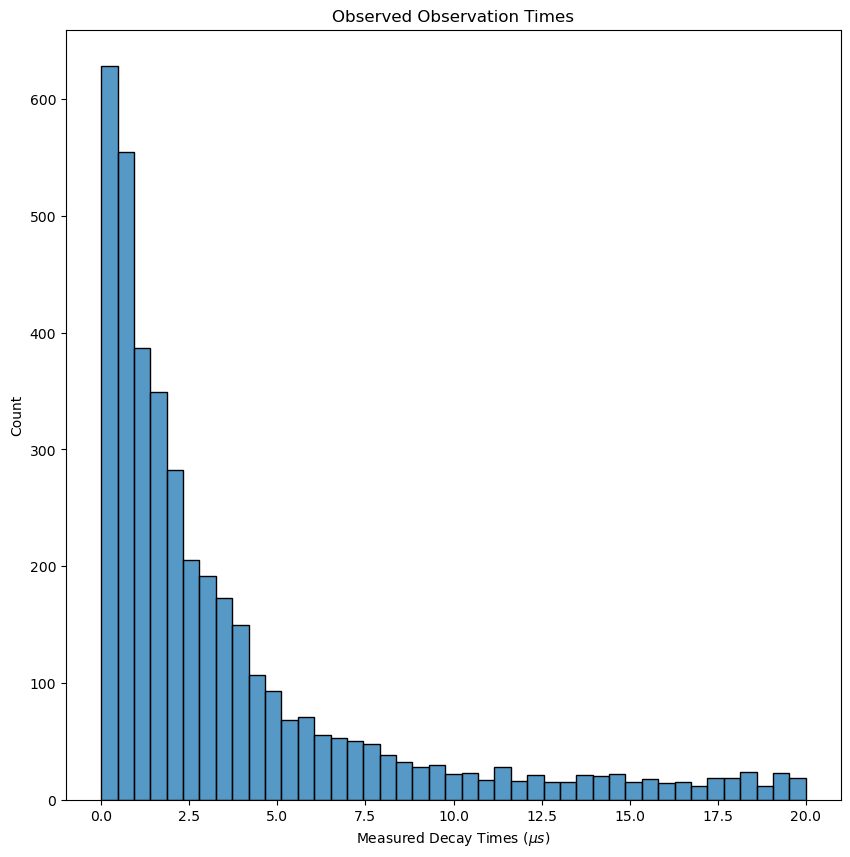

In [54]:
synth_data = gen_data([2.2], 0.8, 4004).astype(np.float64) * 10**(-3)
print(max(synth_data), min(synth_data))

# Bin detected decays into a histogram
width = 0.5
tau_distribution_synth, bin_edges = np.histogram(synth_data, bins=np.arange(min(synth_data), max(synth_data) + width, width))

#Calculate centers of the bins
bin_centers = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2

# Plot histogram of experimental data
plt.figure(figsize=(10,10))
ax = sns.histplot(synth_data)
plt.title("Observed Observation Times")
plt.xlabel("Measured Decay Times ($\\mu s$)")

In [55]:
stan_code = """

data {
    int<lower=1> N; // Size of the data
    // vector[N] x; // Bin centers (each bin is a range of the end point of a time interval)
    vector[N] y; // Number of events (histogram heights)
}

parameters {
    real<lower=0> lambda; // Decay rate of a muon
    // real beta; // Regression parameter
    // real a; // Lower bound of uniform distribution
    // real b; // Upper bound of uniform distribution
    // real<lower=0> alpha;
    real<lower=0,upper=1> w; // Weight for the exponential (muon) distribution
}

model {
    // Priors
    // lambda ~ gamma(9, 0.5);
    lambda ~ inv_gamma(3, 1);
    // alpha ~ inv_gamma(3, 1);
    // alpha ~ gamma(1, 2);
    // beta ~ normal(0, 2);
    // a ~ normal(20, 2);
    // a ~ uniform(1, 5);
    // b ~ truncated_normal(20, 2);
    // b ~ uniform(6, 20);
    // w ~ uniform(0, 20);
    w ~ beta(2, 2);

    for(n in 1:N){
        target += log_sum_exp(log(w) + 
                          exponential_lpdf(y[n] | lambda),
                          // gamma_lpdf(y[n] | 1, lambda),
                          log1m(w) +
                          uniform_lpdf(y[n] | 0.001, 20));
    }
}

"""

In [56]:
# Fit synthetic data using the Stan model to see if parameter recovery of the mixture weights is possible
data_dict = {
    # "N": bin_centers.shape[0],
    "N": synth_data.shape[0],
    # "x": bin_centers,
    # "y": tau_distribution_synth
    "y": synth_data
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.

In [57]:
# Fit the synthetic data
fit = model.sample(num_chains=4, num_samples=4000, num_warmup=1000)

Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   0% (3/20000)
Sampling:   0% (4/20000)
Sampling:   1% (103/20000)
Sampling:   1% (202/20000)
Sampling:   2% (301/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1800/20000)
Sampling:  10% (1900/20000)
Sampling:  10% (2000/20000)
Sampling:  10% (2100/20000)
Sampling:  11% (2200/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000

In [58]:
tau_estimated = 1/fit["lambda"][0]
w_estimated = fit['w'][0]

print(f"Mean Tau: {np.round(np.mean(tau_estimated), 3)} ± {np.round(np.std(tau_estimated))} 𝜇𝑠") #Is the mean even what we actually want? (DEBUG)
az.summary(fit, var_names=['lambda', 'w', 'a', 'b'], filter_vars="like")

Mean Tau: 2.238 ± 0.0 𝜇𝑠


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.447,0.011,0.426,0.469,0.0,0.0,7376.0,8906.0,1.0
w,0.815,0.010,0.796,0.833,0.0,0.0,7484.0,9049.0,1.0


array([[<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

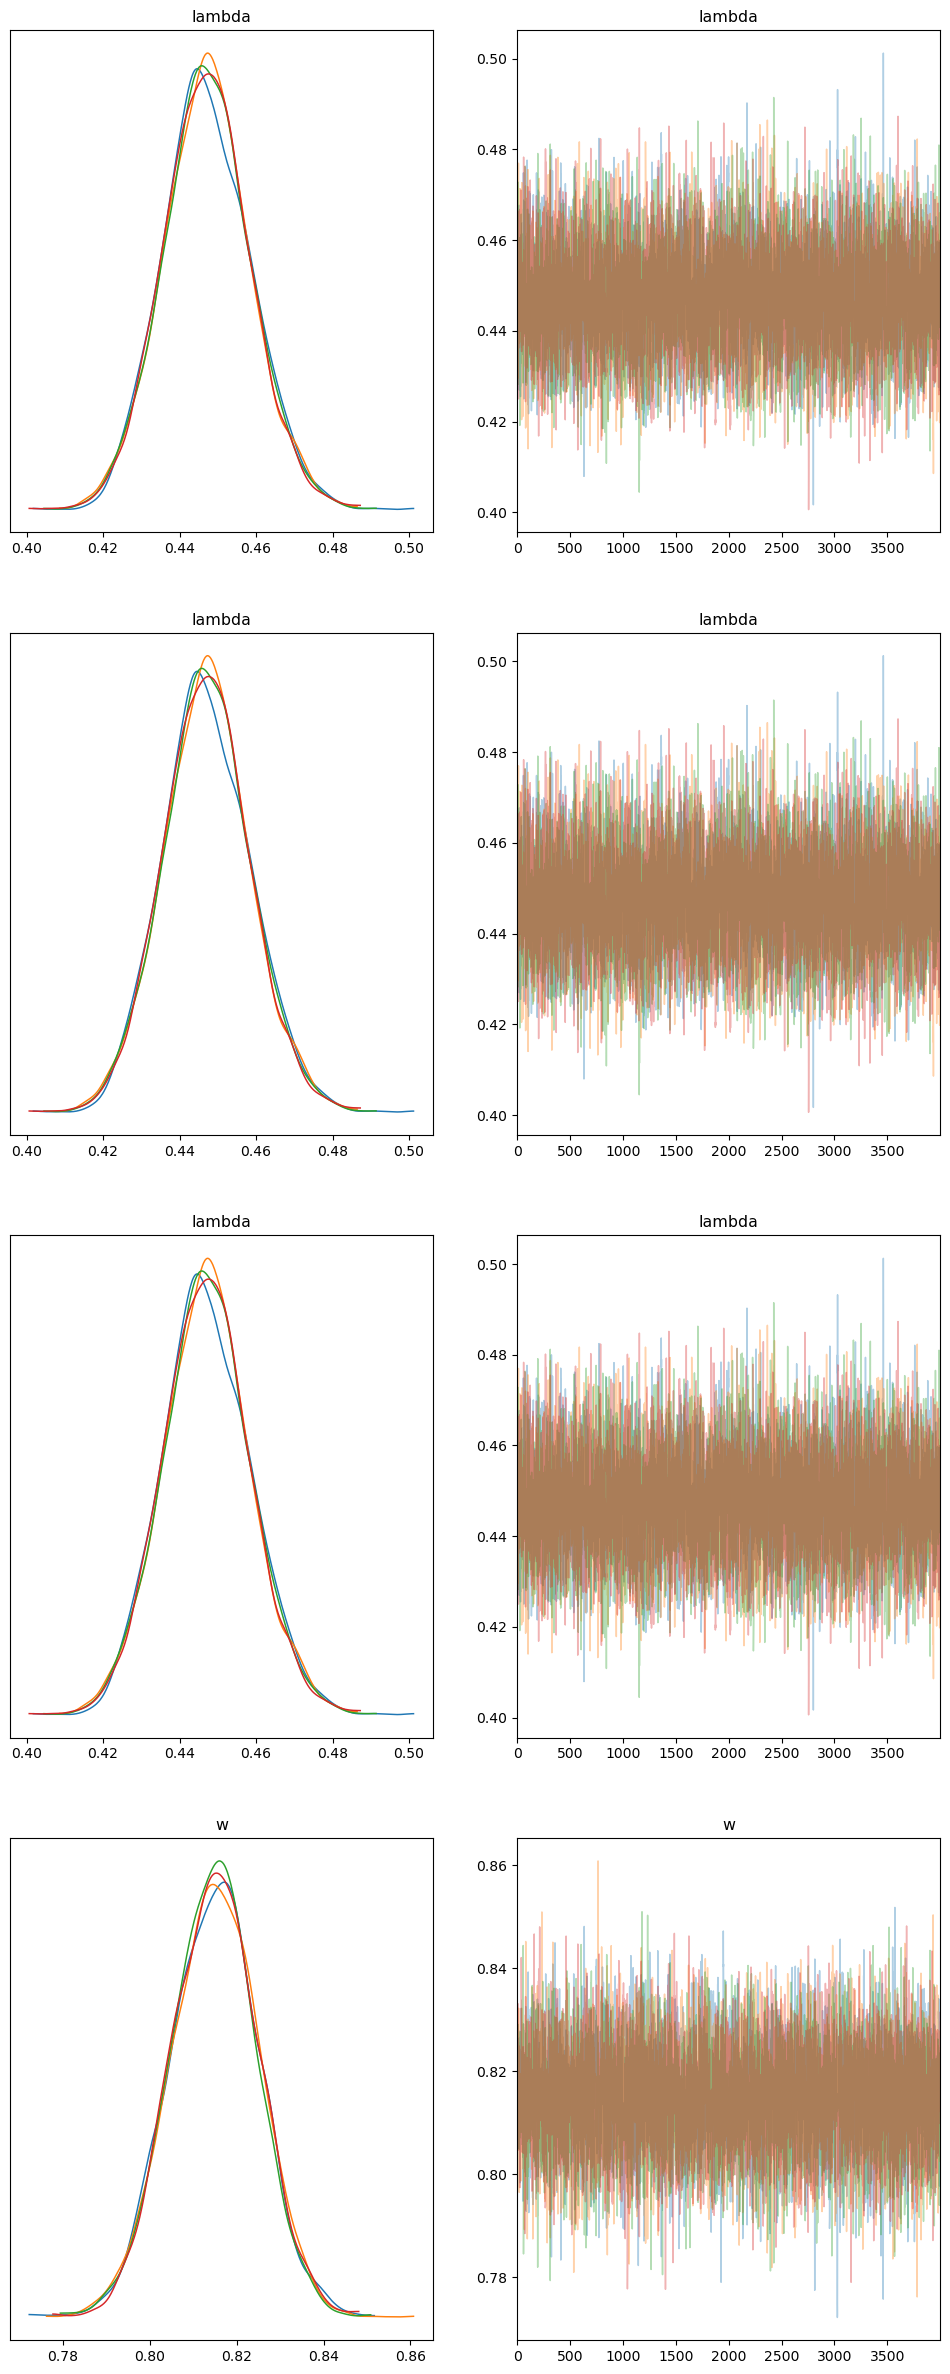

In [59]:
columns_to_plot_trace_of = ['lambda', 'w', 'a', 'b']

az.plot_trace(fit, var_names=columns_to_plot_trace_of, filter_vars='like', compact=False, figsize=(12, 30))

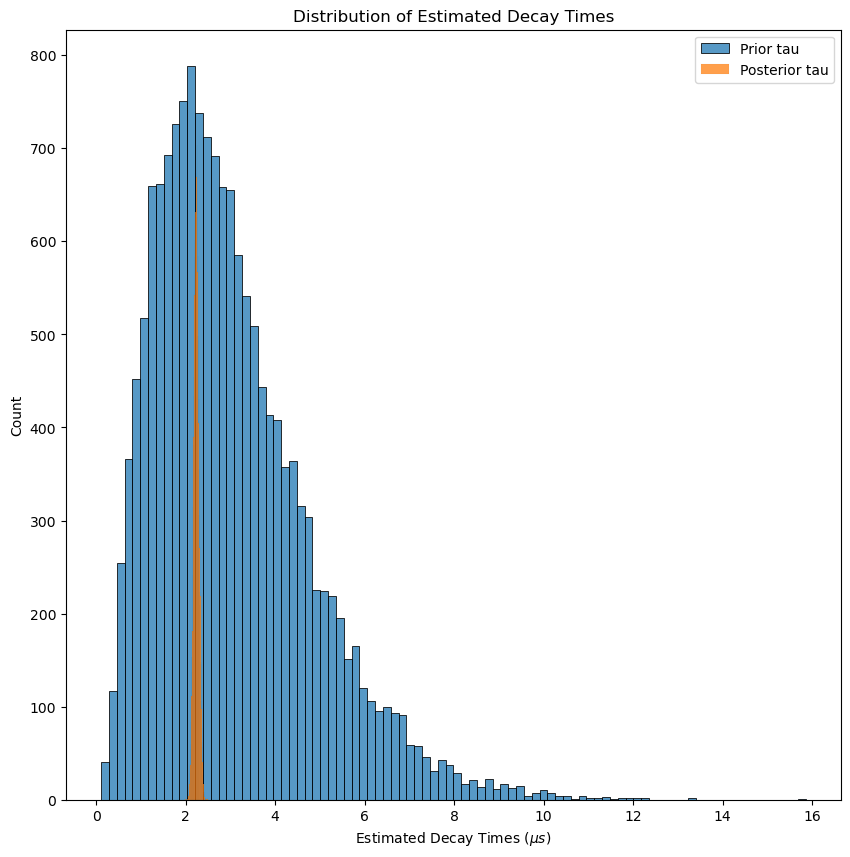

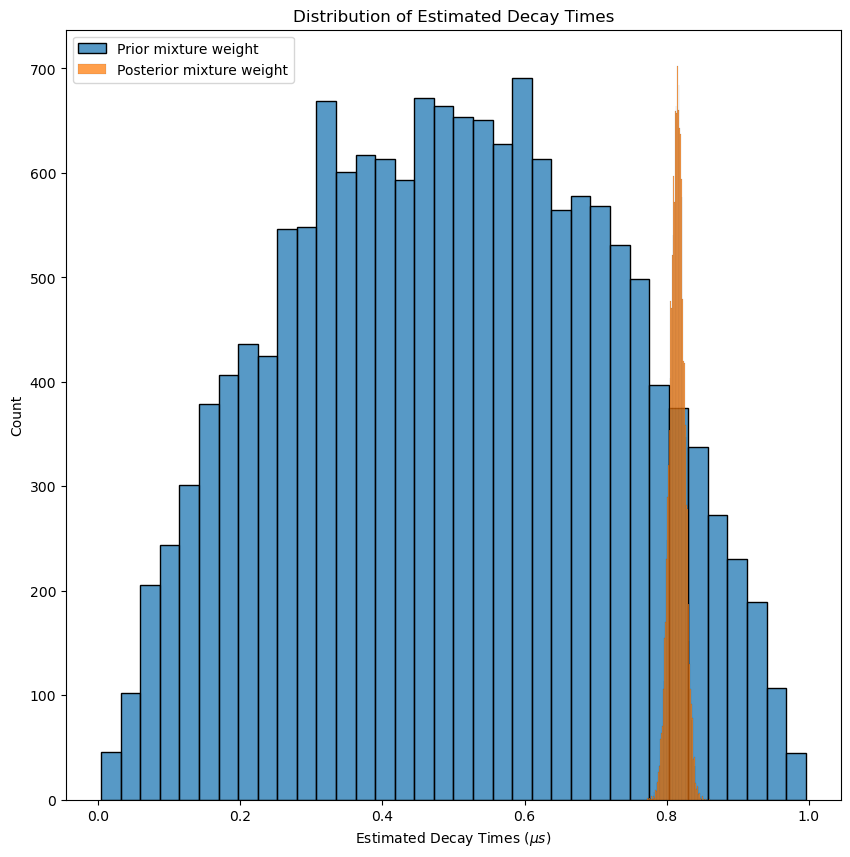

In [60]:
# Plot prior and posterior distributions of the decay time
tau_prior = np.random.gamma(3, scale=1, size=tau_estimated.shape)
plt.figure(figsize=(10,10))
sns.histplot(tau_prior, label="Prior tau")
sns.histplot(tau_estimated, label="Posterior tau")
plt.title("Distribution of Estimated Decay Times")
plt.xlabel("Estimated Decay Times ($\\mu s$)")
plt.legend()
plt.show()

# Plot prior and posterior distributions of the weight
w_prior = np.random.beta(2, 2, size=w_estimated.shape)
plt.figure(figsize=(10,10))
sns.histplot(w_prior, label="Prior mixture weight")
sns.histplot(w_estimated, label="Posterior mixture weight")
plt.title("Distribution of Estimated Decay Times")
plt.xlabel("Estimated Decay Times ($\\mu s$)")
plt.legend()
plt.show()

Predictive Posterior Shape: (16000, 4004)
(4004,)


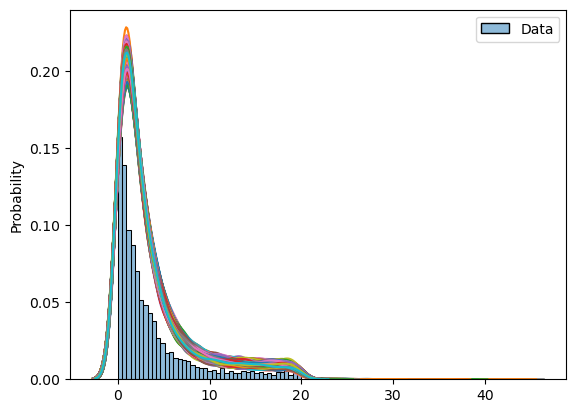

In [61]:
# Predictive Posterior
pred_tau = 1/fit["lambda"][0]
pred_w = fit["w"][0]

pred_posterior = []

for i in range(pred_tau.shape[0]):
    pred_posterior.append(gen_data([pred_tau[i]], pred_w[i], 4004).astype(np.float64) * 10**(-3))

pred_posterior = np.array(pred_posterior)
print(f"Predictive Posterior Shape: {pred_posterior.shape}")

# ax = sns.histplot({'Data': tau_distribution_synth}, kde=True, stat='probability')
ax = sns.histplot({'Data': synth_data}, stat='probability')
print(pred_posterior[0].shape)
for i in range(pred_posterior.shape[0]):
    sns.kdeplot(pred_posterior[i])
# ax.axvline(pred_posterior, color='blue', linestyle='dotted', lw=4)

### Fitting Real Data

In [62]:
# Read in data
data = pd.read_csv("Data/sifted.csv", delimiter=';')
data = data.sample(frac=1).reset_index(drop=True)
print(data)
tau_experimental = np.array(data["ObsTime"].astype(np.float64) * 10**(-3)) # Separate the decay times and convert them from nanoseconds to microseconds

      ObsTime       Epoch
0        2700  1690484462
1         360  1690366664
2        2360  1690344237
3         600  1690568117
4         280  1690399889
...       ...         ...
4000     1620  1690454777
4001      460  1690315367
4002     3980  1690346544
4003     4320  1690458564
4004     3240  1690323231

[4005 rows x 2 columns]


19.84 0.04


Text(0.5, 0, 'Measured Decay Times ($\\mu s$)')

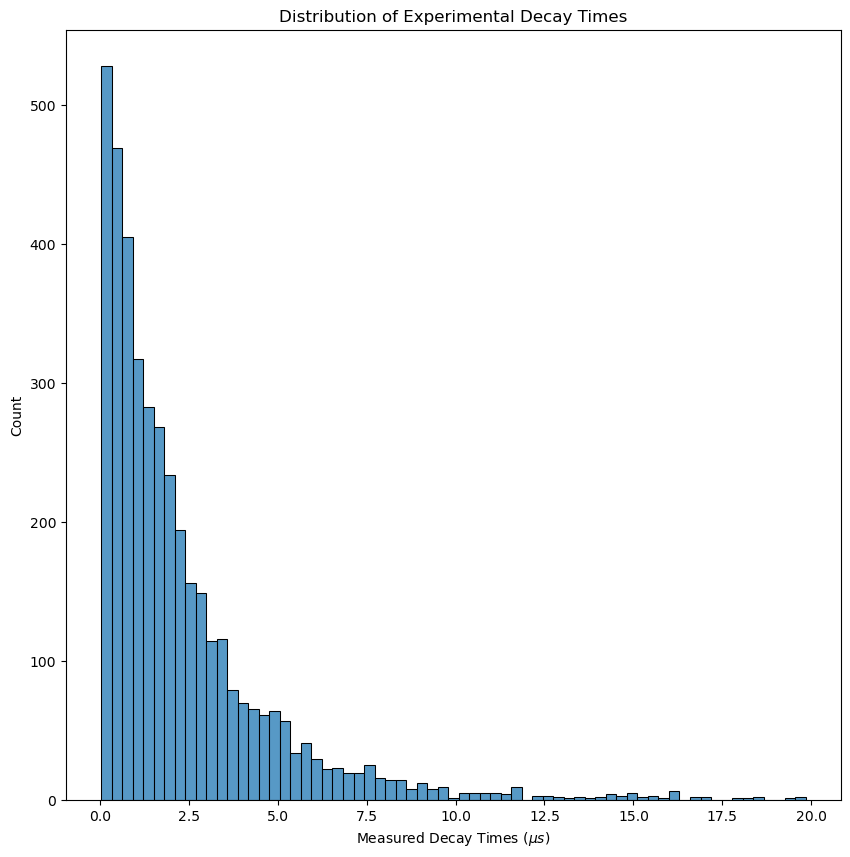

In [63]:
# Bin detected decays into a histogram
width = 0.5
tau_distribution, bin_edges = np.histogram(tau_experimental, bins=np.arange(min(tau_experimental), max(tau_experimental) + width, width))

print(max(tau_experimental), min(tau_experimental)) #(DEBUG)

# Plot histogram of experimental data
plt.figure(figsize=(10,10))
ax = sns.histplot(tau_experimental)
plt.title("Distribution of Experimental Decay Times")
plt.xlabel("Measured Decay Times ($\\mu s$)")

In [64]:
# Stan model
data_dict = {
    "N": tau_experimental.shape[0],
    "y": tau_experimental
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.

In [65]:
fit = model.sample(num_chains=4, num_samples=4000, num_warmup=1000)

Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   0% (2/20000)
Sampling:   0% (3/20000)
Sampling:   0% (4/20000)
Sampling:   1% (103/20000)
Sampling:   1% (202/20000)
Sampling:   2% (301/20000)
Sampling:   2% (400/20000)
Sampling:   2% (500/20000)
Sampling:   3% (600/20000)
Sampling:   4% (700/20000)
Sampling:   4% (800/20000)
Sampling:   4% (900/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1100/20000)
Sampling:   6% (1200/20000)
Sampling:   6% (1300/20000)
Sampling:   7% (1400/20000)
Sampling:   8% (1500/20000)
Sampling:   8% (1600/20000)
Sampling:   8% (1700/20000)
Sampling:   9% (1800/20000)
Sampling:  10% (1900/20000)
Sampling:  10% (2000/20000)
Sampling:  10% (2100/20000)
Sampling:  11% (2200/20000)
Sampling:  12% (2300/20000)
Sampling:  12% (2400/20000)
Sampling:  12% (2500/20000)
Sampling:  13% (2600/20000)
Sampling:  14% (2700/20000)
Sampling:  14% (2800/20000)
Sampling:  14% (2900/20000)
Sampling:  15% (3000/20000)
Sampling:  16% (3100/20000)
Sampling:  16% (3200/20000

In [66]:
tau_estimated = 1/fit["lambda"][0]
w_estimated = fit['w'][0]

print(f"Mean Tau: {np.round(np.mean(tau_estimated), 3)} ± {np.round(np.std(tau_estimated))} 𝜇𝑠") #Is the mean even what we actually want? (DEBUG)
az.summary(fit, var_names=['lambda', 'w'], filter_vars="like")

Mean Tau: 2.116 ± 0.0 𝜇𝑠


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.473,0.009,0.456,0.489,0.0,0.0,8775.0,9547.0,1.0
w,0.975,0.004,0.967,0.984,0.0,0.0,8679.0,9363.0,1.0


array([[<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

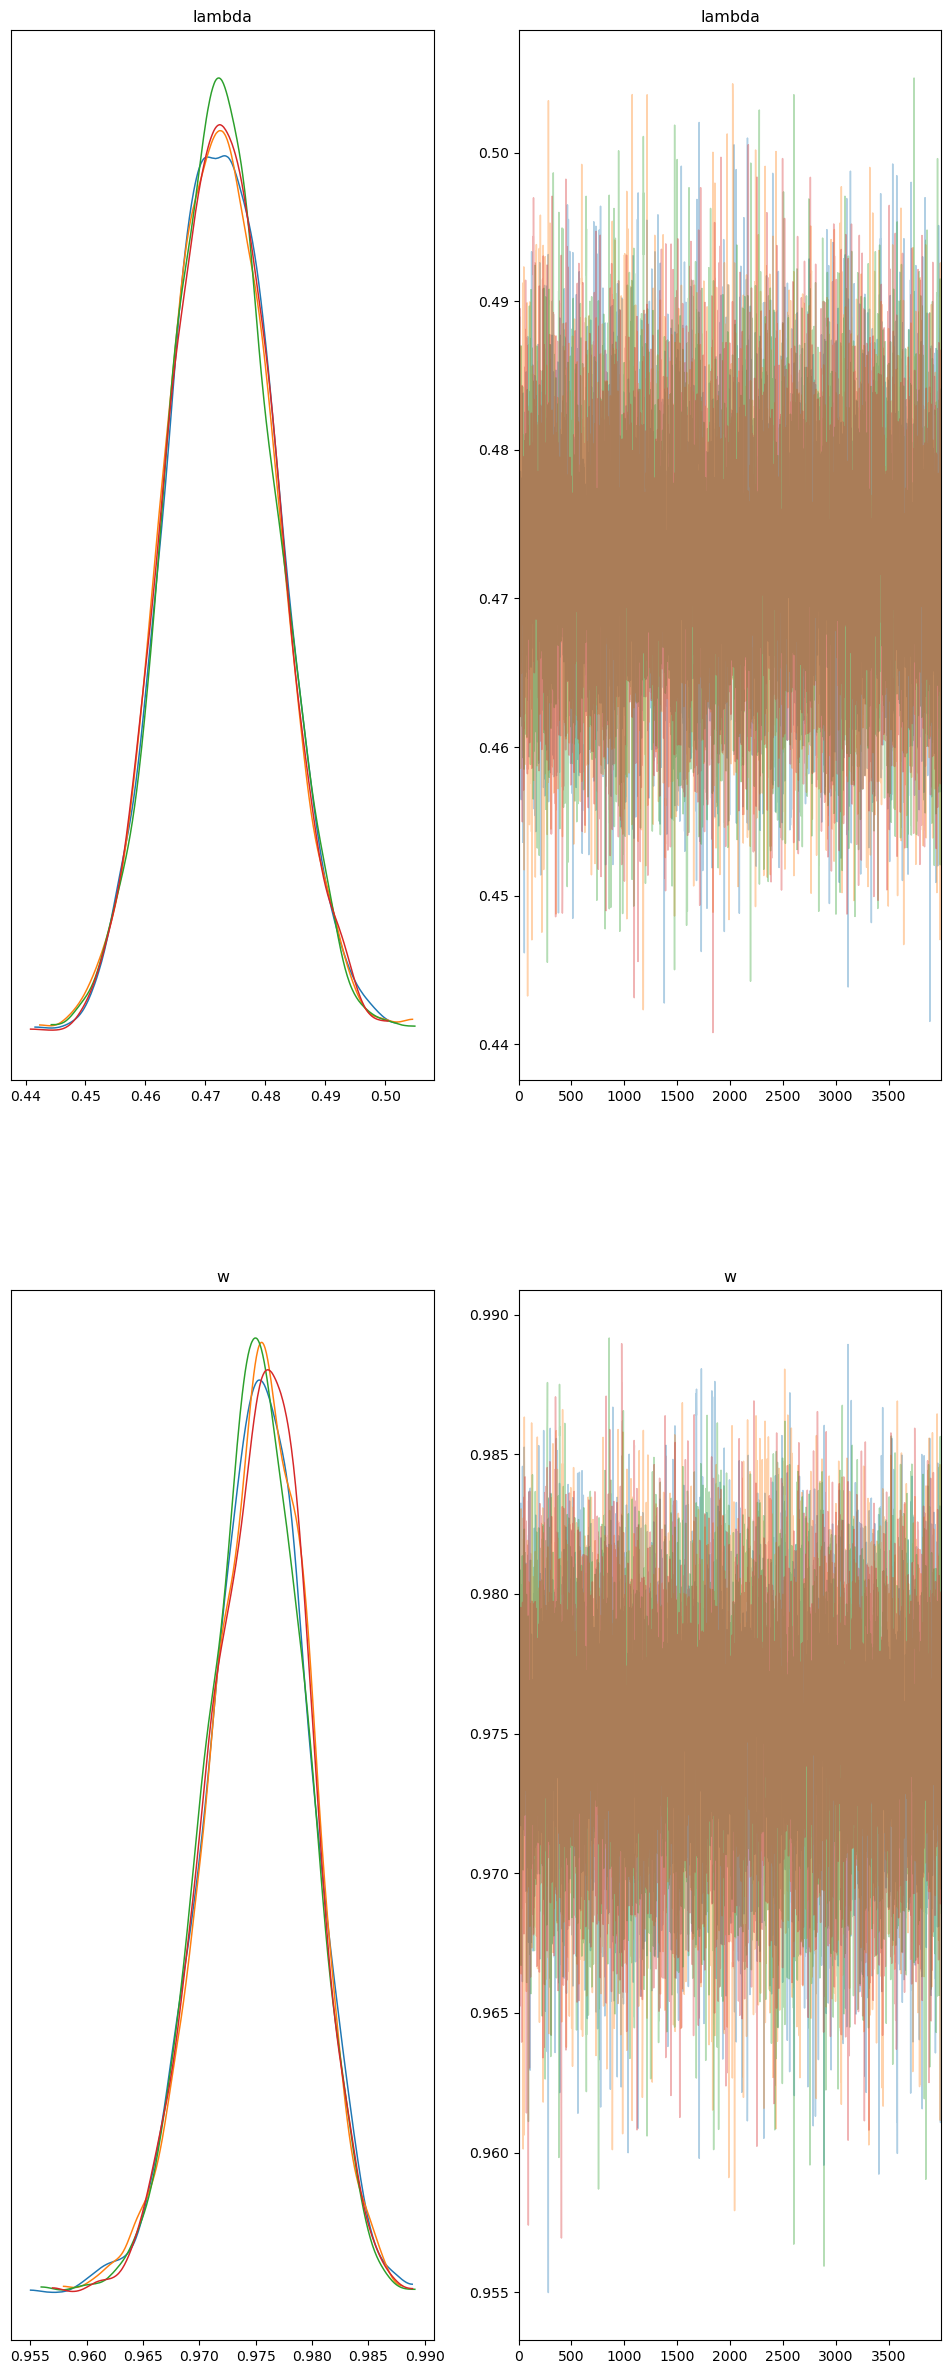

In [67]:
columns_to_plot_trace_of = ['lambda', 'w']

az.plot_trace(fit, var_names=columns_to_plot_trace_of, filter_vars='like', compact=False, figsize=(12, 30))

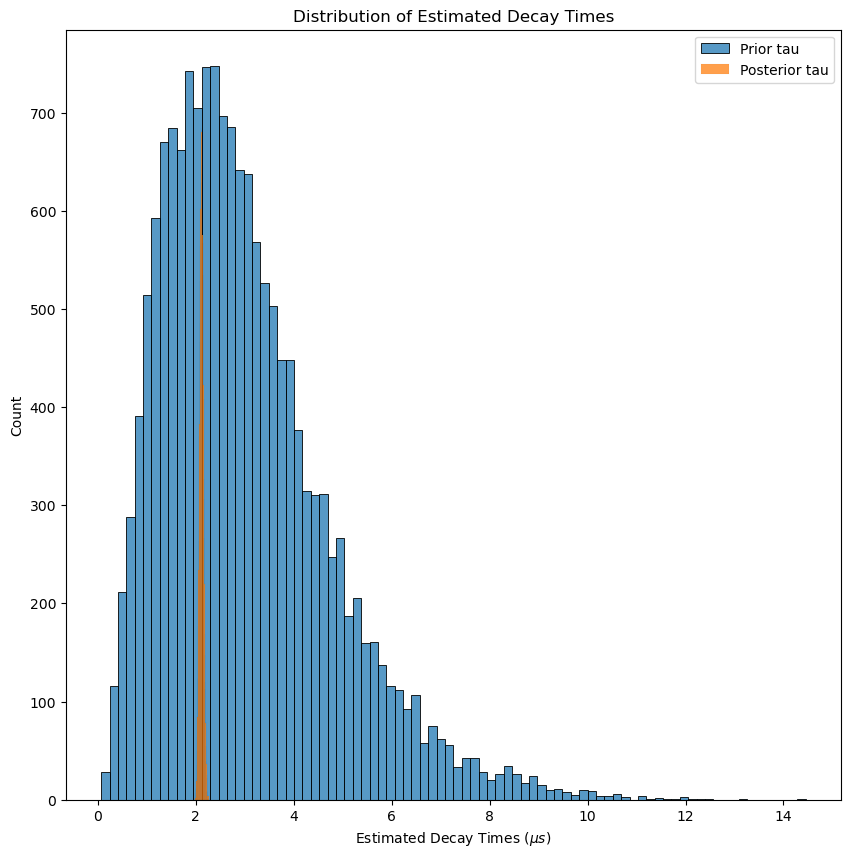

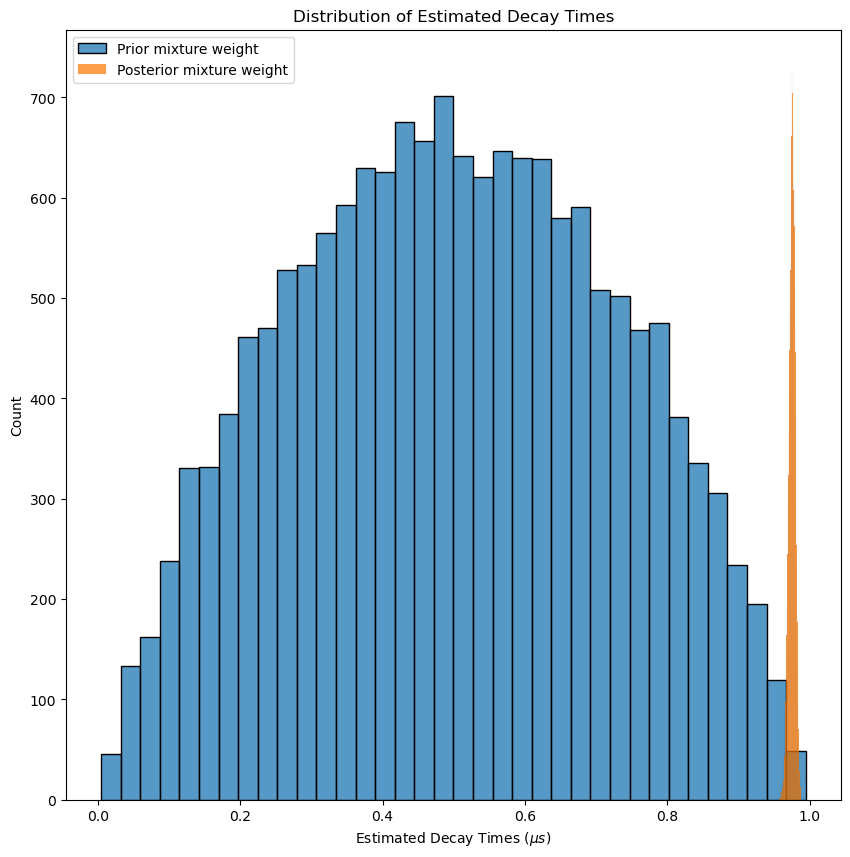

In [68]:
# Plot prior and posterior distributions of the decay time
tau_prior = np.random.gamma(3, scale=1, size=tau_estimated.shape)
plt.figure(figsize=(10,10))
sns.histplot(tau_prior, label="Prior tau")
sns.histplot(tau_estimated, label="Posterior tau")
plt.title("Distribution of Estimated Decay Times")
plt.xlabel("Estimated Decay Times ($\\mu s$)")
plt.legend()
plt.show()

# Plot prior and posterior distributions of the weight
w_prior = np.random.beta(2, 2, size=w_estimated.shape)
plt.figure(figsize=(10,10))
sns.histplot(w_prior, label="Prior mixture weight")
sns.histplot(w_estimated, label="Posterior mixture weight")
plt.title("Distribution of Estimated Decay Times")
plt.xlabel("Estimated Decay Times ($\\mu s$)")
plt.legend()
plt.show()

Predictive Posterior Shape: (16000, 4004)
(4004,)


/home/smidta/anaconda3/envs/cognitive/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


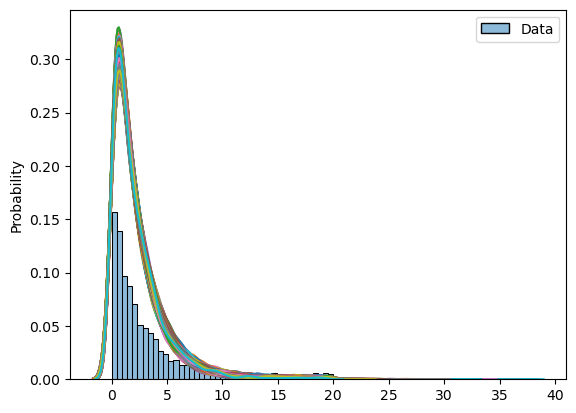

In [69]:
# Predictive Posterior
pred_tau = 1/fit["lambda"][0]
pred_w = fit["w"][0]

pred_posterior = []

for i in range(pred_tau.shape[0]):
    pred_posterior.append(gen_data([pred_tau[i]], pred_w[i], 4004).astype(np.float64) * 10**(-3))

pred_posterior = np.array(pred_posterior)
print(f"Predictive Posterior Shape: {pred_posterior.shape}")

# ax = sns.histplot({'Data': tau_distribution_synth}, kde=True, stat='probability')
ax = sns.histplot({'Data': synth_data}, stat='probability')
print(pred_posterior[0].shape)
for i in range(pred_posterior.shape[0]):
    sns.kdeplot(pred_posterior[i])
# ax.axvline(pred_posterior, color='blue', linestyle='dotted', lw=4)